In [342]:
# General 
import sys
import math
import numpy as np
import pandas as pd
import casadi as cas
#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
from scipy import integrate

In [343]:
u = pd.read_csv('/home/johanna/MasterThesis/Wind_data/timing_investigation_input.csv')
u = u.to_numpy()
state = pd.read_csv('/home/johanna/MasterThesis/Wind_data/timing_investigation_state.csv')
state = state.to_numpy()
state_pred = pd.read_csv('/home/johanna/MasterThesis/Wind_data/timing_investigation_state_pred.csv')
state_pred = state_pred.to_numpy()
wind = pd.read_csv('/home/johanna/MasterThesis/Wind_data/timing_investigation_wind.csv')
wind = wind.to_numpy()

<IPython.core.display.Javascript object>


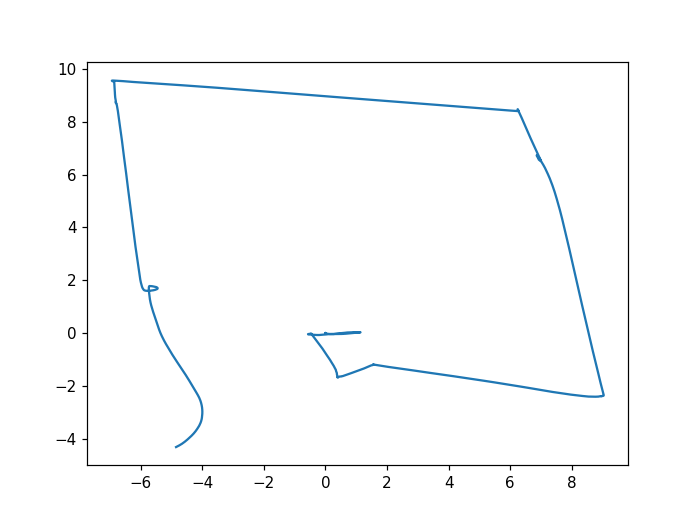

In [344]:
%matplotlib notebook
plt.plot(state[:,1], state[:,2])

In [345]:
u[:,1:3] = u[:,1:3]*math.pi/180
state[:,5:7] = state[:,5:7]*math.pi/180

<IPython.core.display.Javascript object>


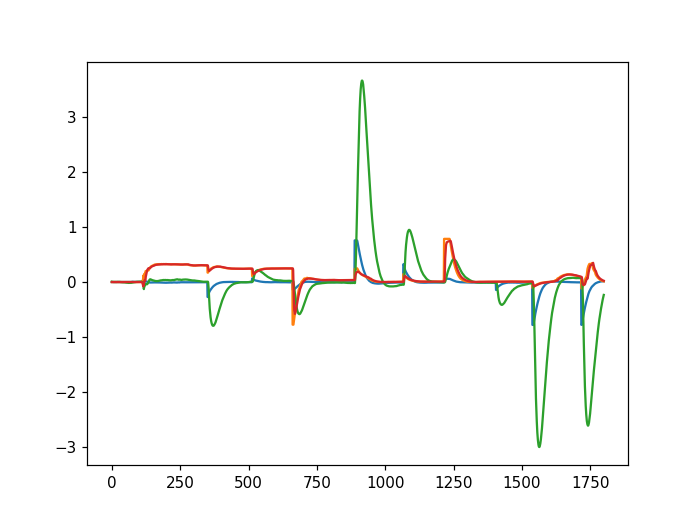

In [346]:
%matplotlib notebook
plt.plot(u[:,1:3])
#plt.plot(state[:,5:7])

In [347]:
inp = u[:,1:]
state_ = state[:,1:]

In [348]:
def integrate_model(model, state_init, u, dt, n=1, method='RK45'):
    state_cur = state_init
    if n != 1:
        n_states = len(model.initial_states)
        states_new = np.empty((n, n_states))

    for i in range(n):
        if method == 'RK4':
            state_cur = solve_rk4(model.continuous_model, state_cur, u, dt)
        else:
            solve_info = integrate.solve_ivp(lambda t, y: model.continuous_model(t, y, u), (0, dt), tuple(state_cur),
                                             method=method)
            state_cur = np.array(solve_info.y[:, -1])
        if n != 1:
            states_new[i, :] = state_cur
        else:
            states_new = state_cur

    return states_new

In [349]:
class DynamicalModel:
    def __init__(self, dt, rtf, int_method):
        self.dt = dt
        self.rtf = rtf
        self.int_method = int_method
        
    def continuous_model(self, dt, x, u):
        print("'continuous_model(self, dt, x, u)' method should be implemented in the child class!")

    def publish_state(self):
        print("'publish_state(self)' method should be implemented in the child class!")

    def publish_state_pred(self):
        print("'publish_state_pred(self)' method should be implemented in the child class!")
        
class DroneHovergamesModel(DynamicalModel):

    def __init__(self, dt, rtf, int_method):

        # System name
        self.name = 'drone_hovergames'


        # Initialize parent class
        super(DroneHovergamesModel, self).__init__(dt, rtf, int_method)
    
        # Constants
        self.g = 9.81

        # Identified constants
        self.tau_phi = 0.104#0.104 #0.17
        self.k_phi = 0.963#1.04
        self.tau_theta = 0.104 #0.104
        self.k_theta = 0.963
        self.kD = 0.02  # Drag coefficient

    def continuous_model(self, dt, x, u):
        
        vx = x[2]
        vy = x[3]
        
        phi = x[4]
        theta = x[5]
        psi = x[6]
        
        phi_c = u[0]
        theta_c = u[1]
        psi_c = u[2]
        
        x_dot = vx
        y_dot = vy
        
        vx_dot = self.g * theta
        vy_dot = -self.g * phi
        
        phi_dot = (self.k_phi * phi_c - phi) / self.tau_phi
        theta_dot = (self.k_theta * theta_c - theta) / self.tau_theta
        psi_dot = 0
        
        return np.array([x_dot, y_dot, vx_dot, vy_dot, phi_dot, theta_dot, psi_dot])

In [350]:
model =  DroneHovergamesModel(0.05, 1, 'RK4') 

In [351]:
plt.plot(state_[:,3])
plt.plot(state_[:,5])

In [352]:
att_pred = []
vx = []
vy = []
phi = []
psi = []
for i in range(inp.shape[0]-2):
    x_next = integrate_model(model, state_[i,:], inp[i-2,:], 0.05)
    vx.append(x_next[2])
    vy.append(x_next[3])
    phi.append(x_next[4])
    psi.append(x_next[5])
vx = np.array(vx)
vy = np.array(vy)
phi = np.array(phi)
psi = np.array(psi)

<IPython.core.display.Javascript object>


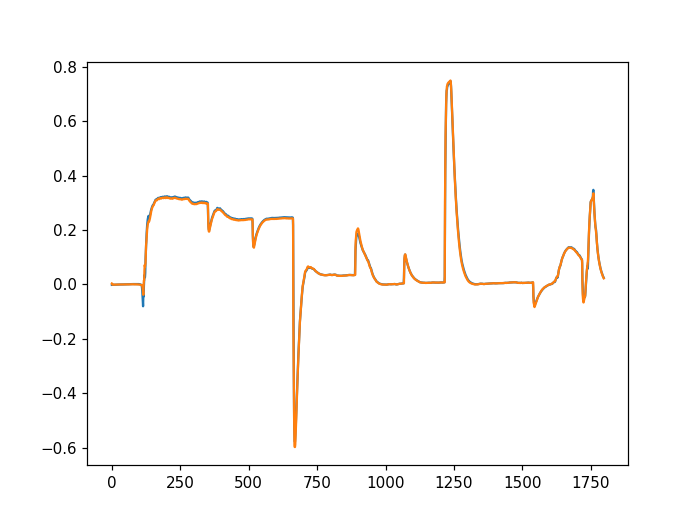

In [376]:
%matplotlib notebook
plt.plot(state_[1:-1,5])
plt.plot(psi)

<IPython.core.display.Javascript object>


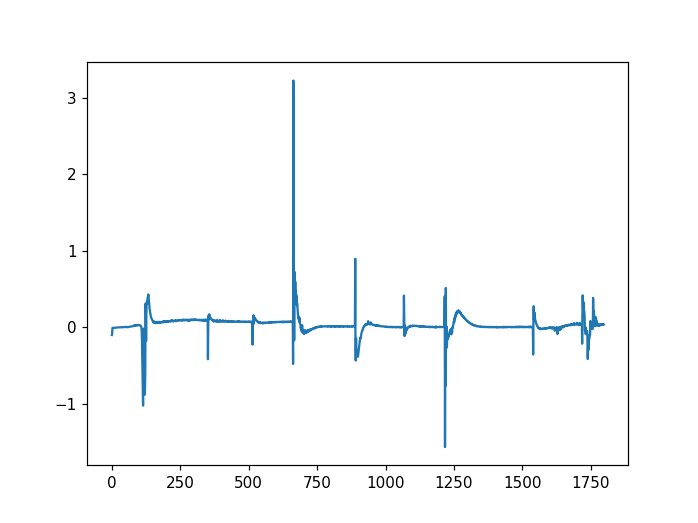

In [373]:
%matplotlib notebook
# plt.plot(vx[:-1])
# plt.plot(state_[1:,2])
# plt.plot((state_[0:-1,3]-vy[1:])/0.05)
plt.plot((state_[1:-1,5]-psi[:])/0.05)
#plt.plot((state_[1:,3]-vy[:-1])/0.05)
# plt.plot((state_[2:,3]-vy[:-2])/0.05)

In [374]:
%matplotlib notebook
# plt.plot(vx[:-1])
# plt.plot(state_[1:,2])
wind_x = (state_[1:-1,2]-vx[:])/0.05
wind_y = (state_[1:-1,3]-vy[:])/0.05

<IPython.core.display.Javascript object>


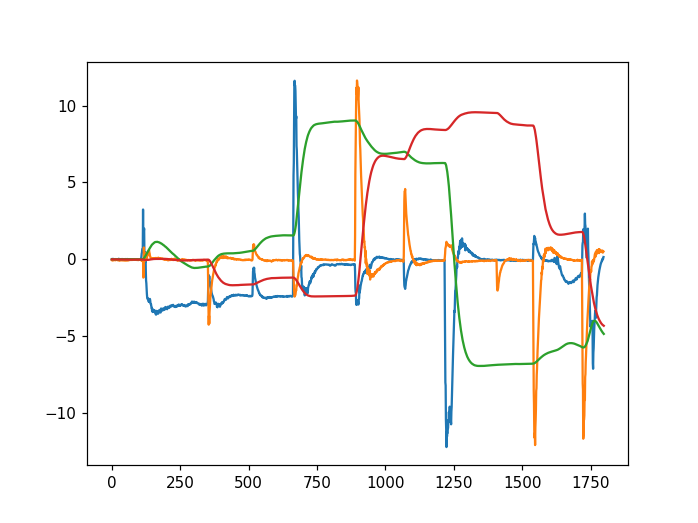

In [375]:
%matplotlib notebook
plt.plot(wind_x)
plt.plot(wind_y)
plt.plot(state_[1:,0])
plt.plot(state_[1:,1])

<IPython.core.display.Javascript object>


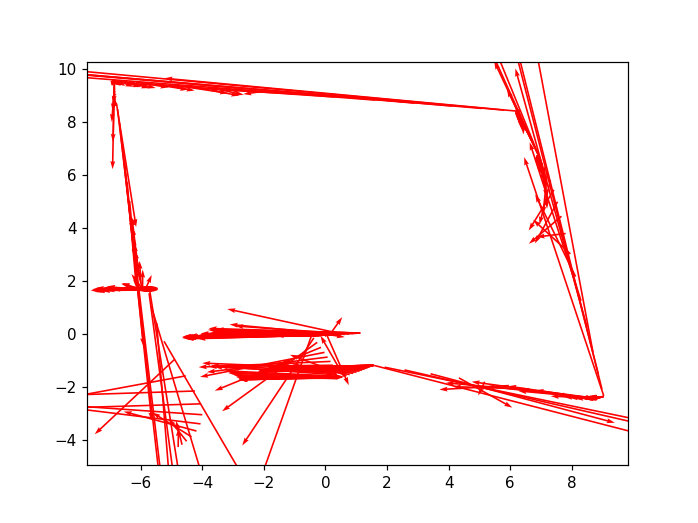

In [358]:
%matplotlib notebook
q = plt.quiver(state_[1::5, 0], state_[1::5, 1], wind_x[::5], wind_y[::5], scale=2.54, color='r',
                       units='width', scale_units="inches", width=0.003)

In [368]:
X = state_[1:-1, 0:2]
print(X.shape)
y = np.transpose(np.vstack([wind_x, wind_y]))
print(y.shape)
np.savez('/home/johanna/MasterThesis/data/wind_data_1.npz', X=X, y=y)

(1798, 2)
(1798, 2)


In [ ]:
# States
        vx = x[3]
        vy = x[4]
        vz = x[5]
        phi = x[6]
        theta = x[7]
        if self.with_yaw:
            psi = x[8]

        # Inputs
        phi_c = u[0]
        theta_c = u[1]
        if not self.with_yaw:
            thrust_c = u[2]
        else:
            dpsi_c = u[2]
            thrust_c = u[3]

        # Calculate derivatives
        x_dot = vx
        y_dot = vy
        z_dot = vz
        if not self.nonlin:
            vx_dot = self.g * theta
            vy_dot = -self.g * phi
            # vx_dot = -self.kD * vx + self.g * theta
            # vy_dot = -self.kD * vy - self.g * phi
            vz_dot = thrust_c - self.g
        else:
            vx_dot = thrust_c * (cas.sin(phi) * cas.sin(psi) + cas.cos(phi) * cas.sin(theta) * cas.cos(psi)) 
            vy_dot = thrust_c * (-cas.sin(phi) * cas.cos(psi) + cas.cos(phi) * cas.sin(theta) * cas.sin(psi)) 
            vz_dot = thrust_c * (cas.cos(phi) * cas.cos(theta)) - self.g 
        phi_dot = (self.k_phi * phi_c - phi) / self.tau_phi
        theta_dot = (self.k_theta * theta_c - theta) / self.tau_theta
        if self.with_yaw:
            psi_dot = dpsi_c
        if not self.with_yaw:
            return np.array([x_dot, y_dot, z_dot, vx_dot, vy_dot, vz_dot, phi_dot, theta_dot])
        else:
            return np.array([x_dot, y_dot, z_dot, vx_dot, vy_dot, vz_dot, phi_dot, theta_dot, psi_dot])


<IPython.core.display.Javascript object>


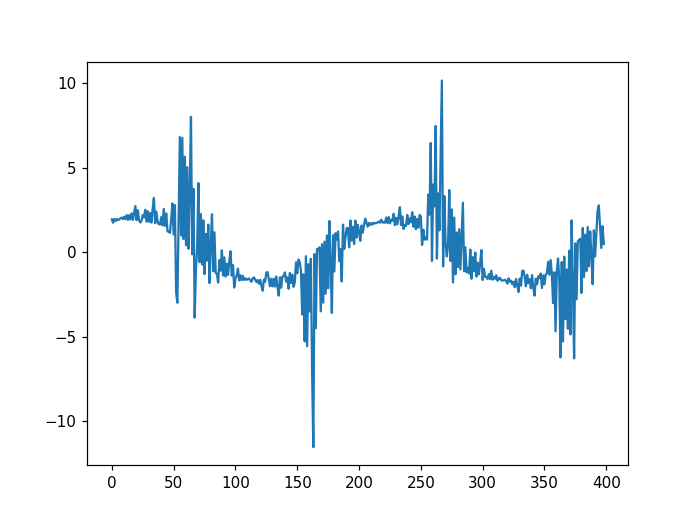

In [311]:
%matplotlib notebook
# plt.plot(state[:,4])
# plt.plot(state_pred[:,4])
plt.plot((state[1:,4]- state_pred[:-1,4])/0.02)

In [356]:
class DynamicalModel:
    def __init__(self, dt, rtf, int_method):
        self.dt = dt
        self.rtf = rtf
        self.int_method = int_method
        
    def continuous_model(self, dt, x, u):
        print("'continuous_model(self, dt, x, u)' method should be implemented in the child class!")

    def publish_state(self):
        print("'publish_state(self)' method should be implemented in the child class!")

    def publish_state_pred(self):
        print("'publish_state_pred(self)' method should be implemented in the child class!")
        
class DroneHovergamesModel(DynamicalModel):

    def __init__(self, dt, rtf, int_method):

        # System name
        self.name = 'drone_hovergames'


        # Initialize parent class
        super(DroneHovergamesModel, self).__init__(dt, rtf, int_method)
    
        # Constants
        self.g = 9.81

        # Identified constants
        self.tau_phi = 0.075#0.104 #0.17
        self.k_phi = 0.963#1.04
        self.tau_theta = 0.075 #0.104
        self.k_theta = 0.963
        self.kD = 0.02  # Drag coefficient

    def continuous_model(self, dt, x, u):
        
        
        phi = x[0]
        phi_c = u[0]
        theta = x[1]
        theta_c = u[1]
        vx_dot = self.g * theta
        phi_dot = (self.k_phi * phi_c - phi) / self.tau_phi
        theta_dot = (self.k_theta * theta_c - theta) / self.tau_theta
        return np.array([vx_dot, phi_dot, theta_dot])

In [357]:
model =  DroneHovergamesModel(0.05, 1, 'RK4') 

<IPython.core.display.Javascript object>


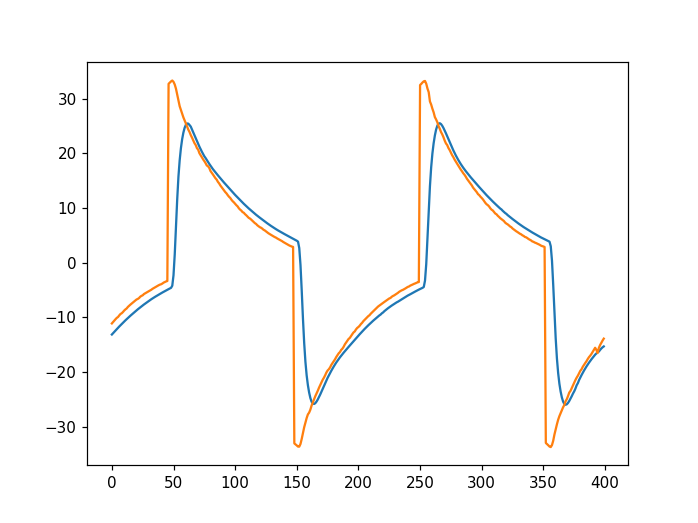

In [336]:
vel = state[:,4]
att = state[:,5]
input_command = u[:,1]
%matplotlib notebook
plt.plot(att)
plt.plot(input_command)
plt.show()

In [384]:
att_pred = []
vx = []
for i in range(len(vel[:-5])):
    x_next = integrate_model(model, [vel[i], input_command[i]*math.pi/180, 1], [att[i]*math.pi/180, 0], 0.02)
    vx.append(x_next[0])
    att_pred.append(x_next[1])
vx = np.array(vx)
att_pred = np.array(att_pred)

<IPython.core.display.Javascript object>


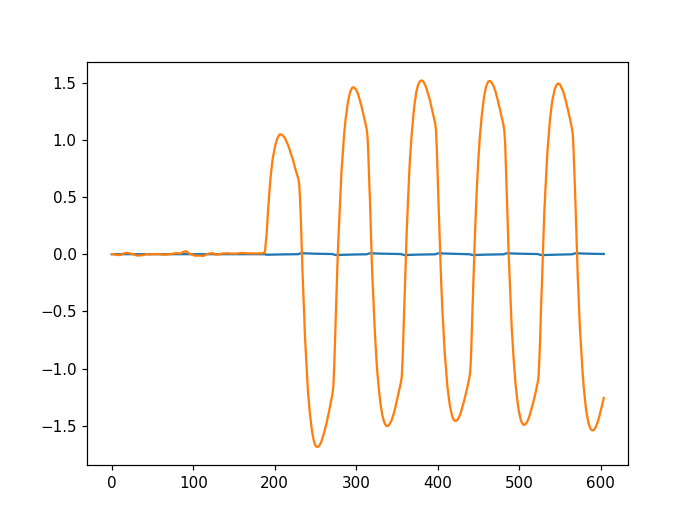

In [385]:
%matplotlib notebook
#plt.plot((vel[1:-4]-vx[:])/0.02)
plt.plot(att*math.pi/180)
plt.plot(vel)
plt.show()
#IDEA: Implement this in C++ and just send to pyhton node afterwards

<IPython.core.display.Javascript object>


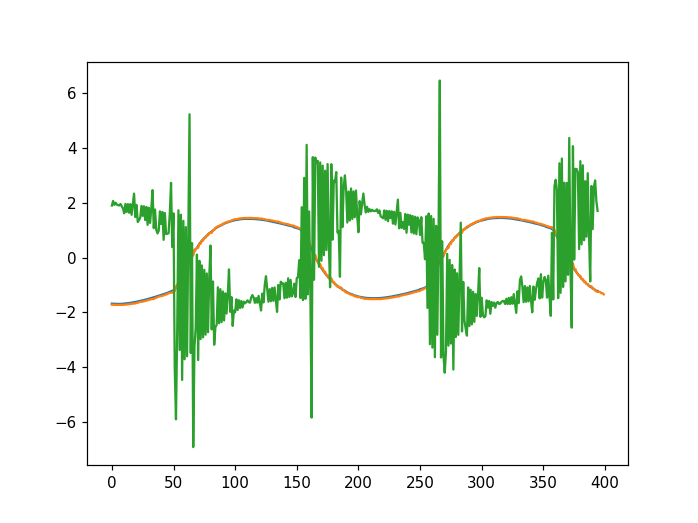

In [339]:
%matplotlib notebook
plt.plot(vx)
plt.plot(state_pred[:,4])
plt.plot((vx[:]-state_pred[1:-4,4])/0.02)

In [416]:
data = pd.read_csv('/home/johanna/test.csv', sep=",")
data = data.to_numpy()

<IPython.core.display.Javascript object>


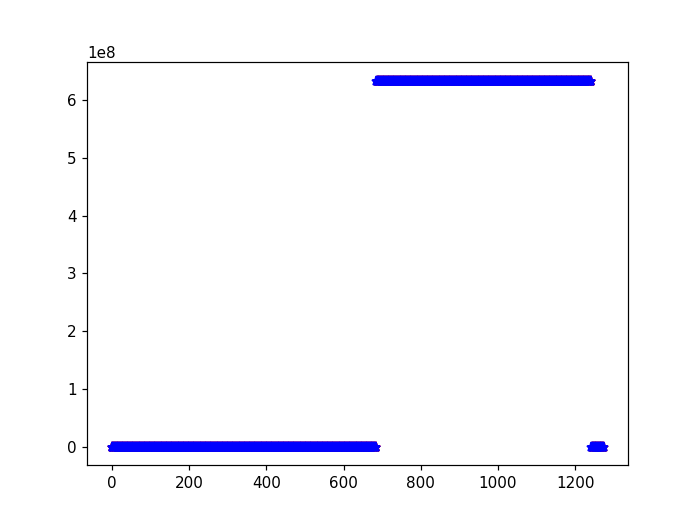

<function matplotlib.pyplot.show(*args, **kw)>

In [417]:
%matplotlib notebook
#plt.plot(data[:,1])
#plt.plot(data[:,0])
plt.plot(data[:,0],'r*')
plt.plot(data[:,1],'b*')
#plt.plot(data[1:1000,0]-data[:999,0])
plt.show

In [418]:
att_pred = []
vx = []
vel = data[:,2]
att = data[:,4]
input_command = data[:,3]
#state_pred = data[:,0]
for i in range(len(vel[144:-1])):
    x_next = integrate_model(model, [vel[144+i], -att[144+i], 1], [-input_command[144+i], 0], 0.05)
    vx.append(x_next[0])
    att_pred.append(x_next[1])
vx = np.array(vx)
att_pred = np.array(att_pred)

In [419]:
print(data[144,0], data[144,1])

21.336 21.356


<IPython.core.display.Javascript object>


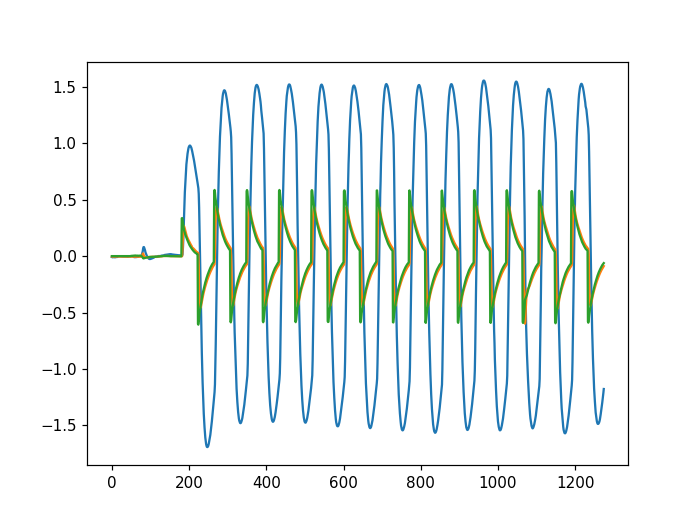

In [420]:
%matplotlib notebook
plt.plot(vel)
plt.plot(-att)
plt.plot(-input_command)


<IPython.core.display.Javascript object>


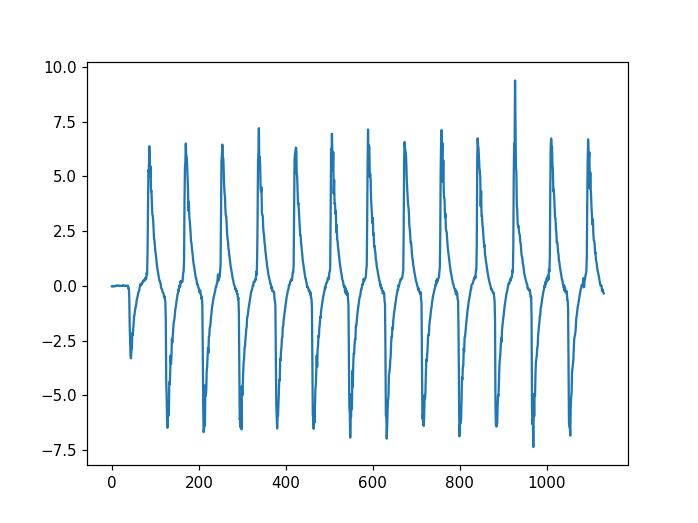

In [427]:
%matplotlib notebook
# plt.plot(vx[:-1], 'r')
#plt.plot(state_pred[:-1], 'g')
# plt.plot(vel[145:], 'b')
# plt.plot(data[144:,5])
plt.plot((vel[142:-1]-data[143:,5])/0.05)
#plt.plot((vel[1:] - state_pred[:-1])/0.02)
#plt.plot((vx[:-1]-vel[145:])/0.05)

In [410]:
data = pd.read_csv('timing_investigation.csv')
data = data.to_numpy()
data_sp = pd.read_csv('timing_investigation_sp.csv')
data_sp = data_sp.to_numpy()

In [411]:
plt.plot(data[:,0], data[:,1])
plt.plot(data_sp[:,0], data_sp[:,1])
plt.show()

In [412]:
print(data[0,0],data_sp[0,0])


21.768 21.752


In [509]:
class DynamicalModel:
    def __init__(self, dt, rtf, int_method):
        self.dt = dt
        self.rtf = rtf
        self.int_method = int_method
        
    def continuous_model(self, dt, x, u):
        print("'continuous_model(self, dt, x, u)' method should be implemented in the child class!")

    def publish_state(self):
        print("'publish_state(self)' method should be implemented in the child class!")

    def publish_state_pred(self):
        print("'publish_state_pred(self)' method should be implemented in the child class!")
        
class DroneHovergamesModel(DynamicalModel):

    def __init__(self, dt, rtf, int_method):

        # System name
        self.name = 'drone_hovergames'


        # Initialize parent class
        super(DroneHovergamesModel, self).__init__(dt, rtf, int_method)
    
        # Constants
        self.g = 9.81

        # Identified constants
        self.tau_phi = 0.12 #0.17
        self.k_phi = 0.963 #1.04
        self.tau_theta = 0.12
        self.k_theta = 0.963
        self.kD = 0.02  # Drag coefficient

    def continuous_model(self, dt, x, u):
        phi = x[0]
        phi_c = u[0]
        theta = x[1]
        theta_c = u[1]
        phi_dot = (self.k_phi * phi_c - phi) / self.tau_phi
        theta_dot = (self.k_theta * theta_c - theta) / self.tau_theta
        return np.array([phi_dot, theta_dot])

In [510]:
u = [12*math.pi/180, 0]

In [514]:
model =  DroneHovergamesModel(0.02, 1, 'RK45')        

In [512]:
x = []
for i in range(len(data[:-1,1])):
    x_next = integrate_model(model, [data[i,1]*math.pi/180,1], [data_sp[i+1,1]*math.pi/180,0], 0.02)
    x.append(x_next[0])
x = np.array(x)

solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45

solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45
solving rk45


<IPython.core.display.Javascript object>


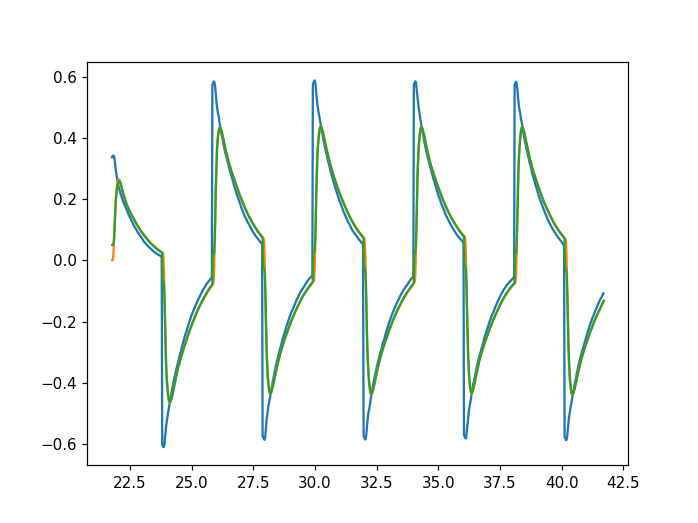

In [502]:
%matplotlib notebook
plt.plot(data_sp[1:,0], data_sp[1:,1]*math.pi/180)
plt.plot(data[1:,0], data[1:,1]*math.pi/180)
plt.plot(data[1:,0], x[:])
plt.show()

<IPython.core.display.Javascript object>


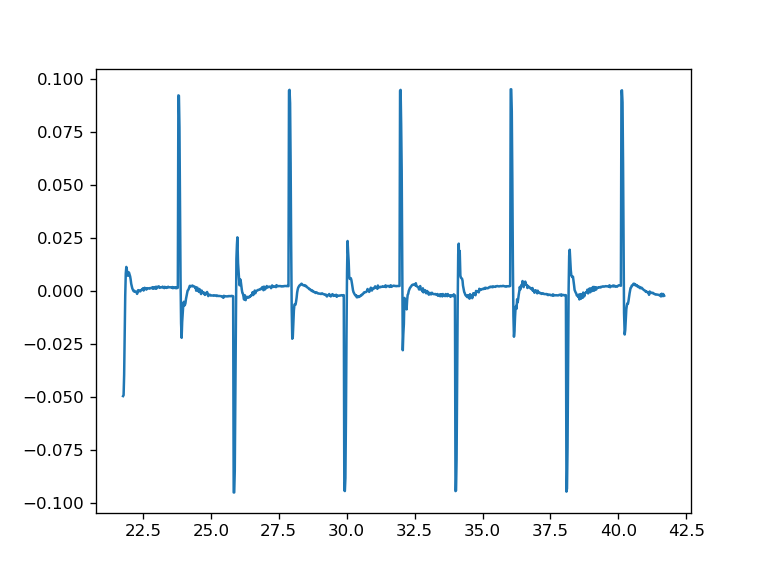

In [373]:
%matplotlib notebook
plt.plot(data[:-1,0], (data[1:,1]*math.pi/180-x[:]))
plt.show()

In [454]:
data_speed = pd.read_csv('timing_investigation_speed.csv')
data_speed = data_speed.to_numpy()
plt.plot(data_speed[1:,0], data_speed[1:,1])
plt.show()

In [455]:
data_speed[1,0]

21.788

In [490]:
class DynamicalModel:
    def __init__(self, dt, rtf, int_method):
        self.dt = dt
        self.rtf = rtf
        self.int_method = int_method
        
    def continuous_model(self, dt, x, u):
        print("'continuous_model(self, dt, x, u)' method should be implemented in the child class!")

    def publish_state(self):
        print("'publish_state(self)' method should be implemented in the child class!")

    def publish_state_pred(self):
        print("'publish_state_pred(self)' method should be implemented in the child class!")
        
class DroneHovergamesModel(DynamicalModel):

    def __init__(self, dt, rtf, int_method):

        # System name
        self.name = 'drone_hovergames'


        # Initialize parent class
        super(DroneHovergamesModel, self).__init__(dt, rtf, int_method)
    
        # Constants
        self.g = 9.81

        # Identified constants
        self.tau_phi = 0.075#0.104 #0.17
        self.k_phi = 0.963#1.04
        self.tau_theta = 0.075 #0.104
        self.k_theta = 0.963
        self.kD = 0.02  # Drag coefficient

    def continuous_model(self, dt, x, u):
        
        
        phi = x[0]
        phi_c = u[0]
        theta = x[1]
        theta_c = u[1]
        vx_dot = self.g * theta
        phi_dot = (self.k_phi * phi_c - phi) / self.tau_phi
        theta_dot = (self.k_theta * theta_c - theta) / self.tau_theta
        return np.array([vx_dot, phi_dot, theta_dot])

In [491]:
model =  DroneHovergamesModel(0.02, 1, 'RK4')        

In [495]:
vx = []
for i in range(len(data[:-1,1])):
    x_next = integrate_model(model, [data_speed[i,1], data[i+1,1]*math.pi/180,1], [data_sp[i+1,1]*math.pi/180,0], 0.02)
    vx.append(x_next[0])
vx = np.array(vx)

<IPython.core.display.Javascript object>


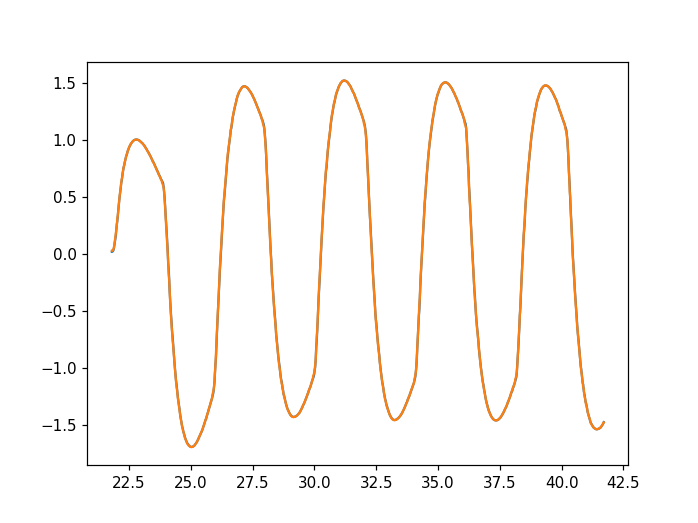

In [496]:
%matplotlib notebook
plt.plot(data_speed[2:,0], data_speed[2:,1])
plt.plot(data[2:,0], vx[1:])
plt.show()

<IPython.core.display.Javascript object>


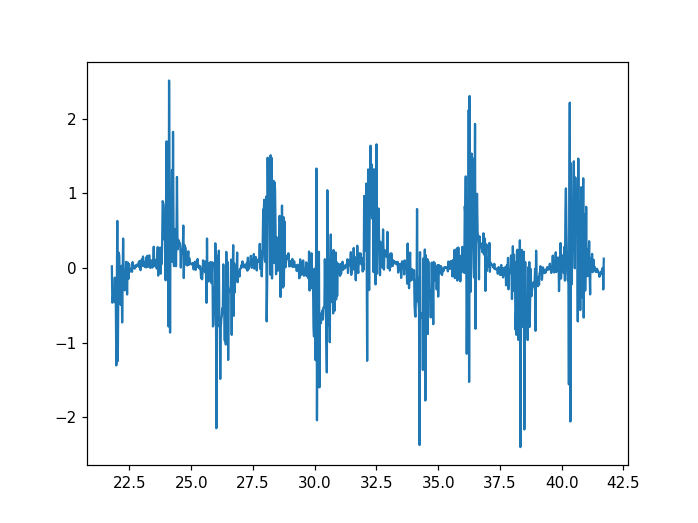

0.027616163018540193

In [497]:
%matplotlib notebook
plt.plot(data_speed[1:,0], (data_speed[1:,1]-vx[:])/0.02)
plt.show()
np.mean((data_speed[1:,1]-vx[:])/0.02)
#IDEA: Implement this in C++ and just send to pyhton node afterwards

<IPython.core.display.Javascript object>


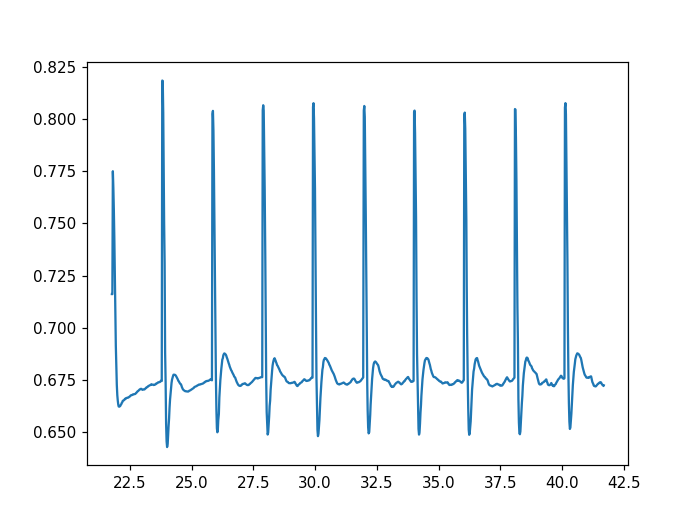

In [475]:
%matplotlib notebook
data_thrust = pd.read_csv('timing_investigation_thrust.csv')
data_thrust = data_thrust.to_numpy()
plt.plot(data_thrust[1:,0], data_thrust[1:,1])
plt.show()

In [476]:
class DynamicalModel:
    def __init__(self, dt, rtf, int_method):
        self.dt = dt
        self.rtf = rtf
        self.int_method = int_method
        
    def continuous_model(self, dt, x, u):
        print("'continuous_model(self, dt, x, u)' method should be implemented in the child class!")

    def publish_state(self):
        print("'publish_state(self)' method should be implemented in the child class!")

    def publish_state_pred(self):
        print("'publish_state_pred(self)' method should be implemented in the child class!")
        
class DroneHovergamesModel(DynamicalModel):

    def __init__(self, dt, rtf, int_method):

        # System name
        self.name = 'drone_hovergames'


        # Initialize parent class
        super(DroneHovergamesModel, self).__init__(dt, rtf, int_method)
    
        # Constants
        self.hover_thrust = 0.675
        self.acc_to_thrust_ratio = 23.258
        self.g = 9.81

        # Identified constants
        
        
        
        self.tau_phi = 0.104#0.104 #0.17
        self.k_phi = 0.963#1.04
        self.tau_theta = 0.104 #0.104
        self.k_theta = 0.963
        self.kD = 0.02  # Drag coefficient

    def continuous_model(self, dt, x, u):
        
        
        phi = x[0]
        psi = 0
        phi_c = u[0]
        theta = x[1]
        theta_c = u[1]
        thrust_c = (u[2] - self.hover_thrust)/self.acc_to_thrust_ratio + self.g
        vx_dot = thrust_c * (cas.sin(phi) * cas.sin(psi) + cas.cos(phi) * cas.sin(theta) * cas.cos(psi)) 
        phi_dot = (self.k_phi * phi_c - phi) / self.tau_phi
        theta_dot = (self.k_theta * theta_c - theta) / self.tau_theta
        return np.array([vx_dot, phi_dot, theta_dot])

In [477]:
model =  DroneHovergamesModel(0.02, 1, 'RK4')

In [486]:
vx = []
for i in range(len(data[:-1,1])):
    x_next = integrate_model(model, [data_speed[i,1], data[i,1]*math.pi/180,1], [data_sp[i+1,1]*math.pi/180,0,data_thrust[i+1,1]], 0.02)
    vx.append(x_next[0])
vx = np.array(vx)

<IPython.core.display.Javascript object>


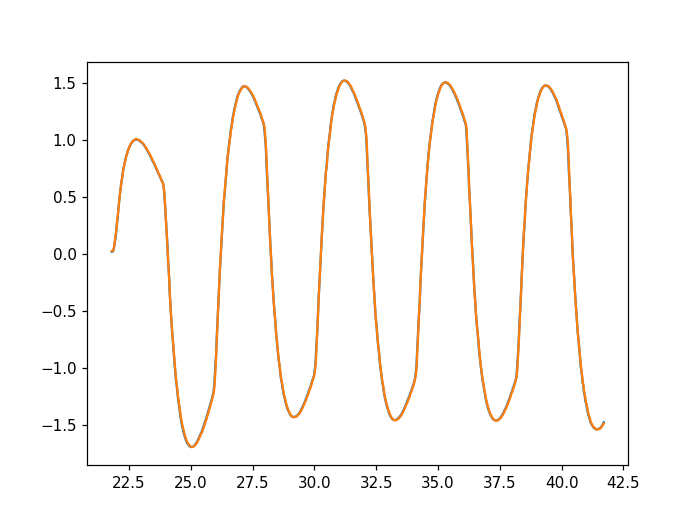

In [487]:
%matplotlib notebook
plt.plot(data_speed[2:,0], data_speed[2:,1])
plt.plot(data[2:,0], vx[1:])
plt.show()

<IPython.core.display.Javascript object>


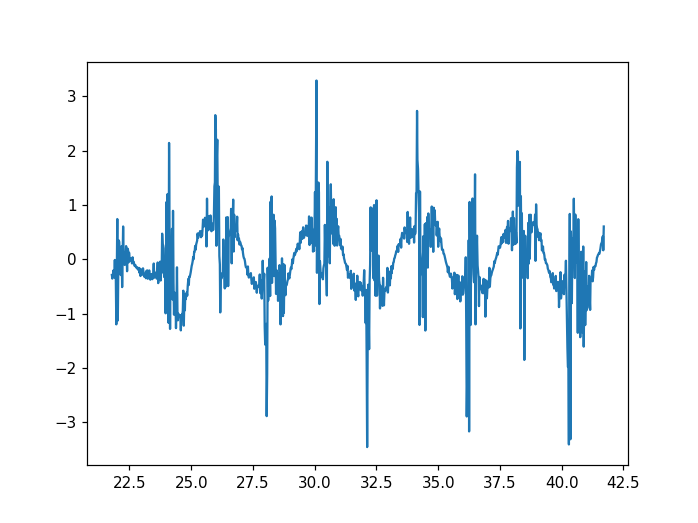

-0.028649473251725018

In [488]:
%matplotlib notebook
plt.plot(data_speed[1:,0], (data_speed[1:,1]-vx[:])/0.02)
plt.show()
np.mean((data_speed[1:,1]-vx[:])/0.02)

<IPython.core.display.Javascript object>


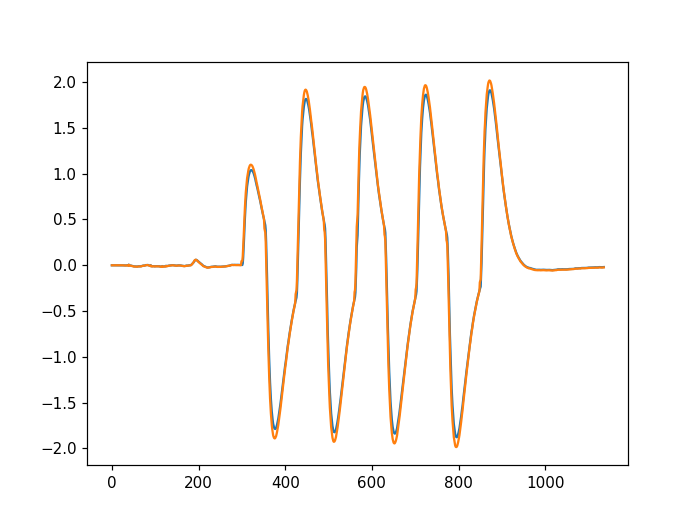

In [413]:
%matplotlib notebook
data1 = np.load('/home/johanna/MasterThesis/data/wind_data_1.npz')
X1 = data1['X'][:,:]
y1 = data1['y'][:,:]
vel = data1['vel'][:,1]
vel_pred = data1['vel_pred'][:,1]
input_command = data1['ctrl'][:,0]
att = data1['att'][:]
plt.plot(vel)
plt.plot(vel_pred)
plt.show()

In [423]:
vel.shape

(1136,)

<IPython.core.display.Javascript object>


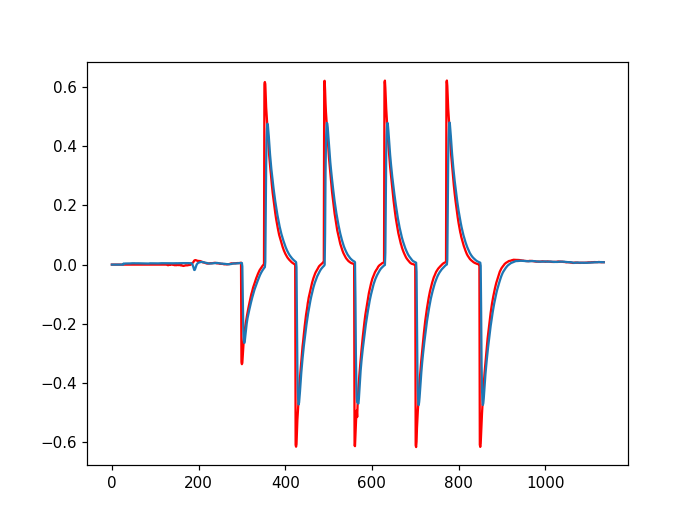

In [415]:
%matplotlib notebook
plt.plot(input_command, 'r')
plt.plot(att)
plt.show()

In [425]:
class DynamicalModel:
    def __init__(self, dt, rtf, int_method):
        self.dt = dt
        self.rtf = rtf
        self.int_method = int_method
        
    def continuous_model(self, dt, x, u):
        print("'continuous_model(self, dt, x, u)' method should be implemented in the child class!")

    def publish_state(self):
        print("'publish_state(self)' method should be implemented in the child class!")

    def publish_state_pred(self):
        print("'publish_state_pred(self)' method should be implemented in the child class!")
        
class DroneHovergamesModel(DynamicalModel):

    def __init__(self, dt, rtf, int_method):

        # System name
        self.name = 'drone_hovergames'


        # Initialize parent class
        super(DroneHovergamesModel, self).__init__(dt, rtf, int_method)
    
        # Constants
        self.g = 9.81

        # Identified constants
        self.tau_phi = 0.075 #0.104 #0.17
        self.k_phi = 0.963 #1.04
        self.tau_theta = 0.075 #0.104
        self.k_theta = 0.963
        self.kD = 0.02  # Drag coefficient

    def continuous_model(self, dt, x, u):
        
        
        phi = x[1]
        phi_c = u[0]
        theta = x[2]
        theta_c = u[1]
        vx_dot = -self.g * phi
        phi_dot = (self.k_phi * phi_c - phi) / self.tau_phi
        theta_dot = (self.k_theta * theta_c - theta) / self.tau_theta
        return np.array([vx_dot, phi_dot, theta_dot])

In [426]:
model =  DroneHovergamesModel(0.02, 1, 'RK4')

In [428]:
att_pred = []
vx = []
for i in range(len(vel[:-1])):
    x_next = integrate_model(model, [vel[i], att[i], 1], [input_command[i], 0], 0.02)
    vx.append(x_next[0])
    att_pred.append(x_next[1])
vx = np.array(vx)
att_pred = np.array(att_pred)

<IPython.core.display.Javascript object>


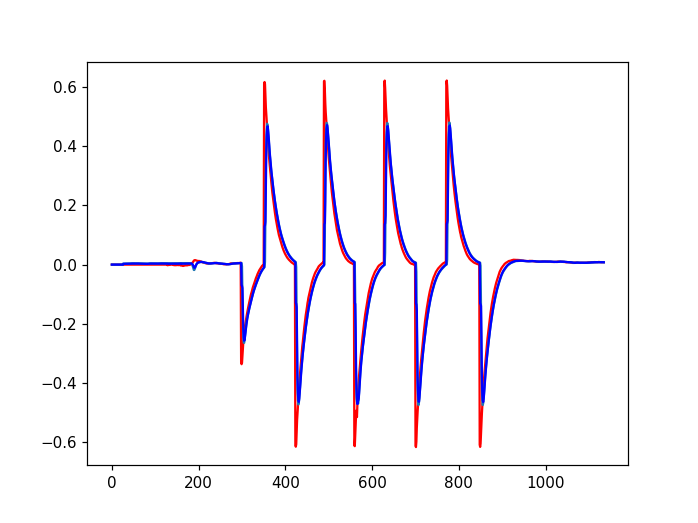

In [429]:
%matplotlib notebook
plt.plot(input_command[1:], 'r')
plt.plot(att[1:])
plt.plot(att_pred[:], 'b')
# plt.plot(vx, 'g')
plt.show()

<IPython.core.display.Javascript object>


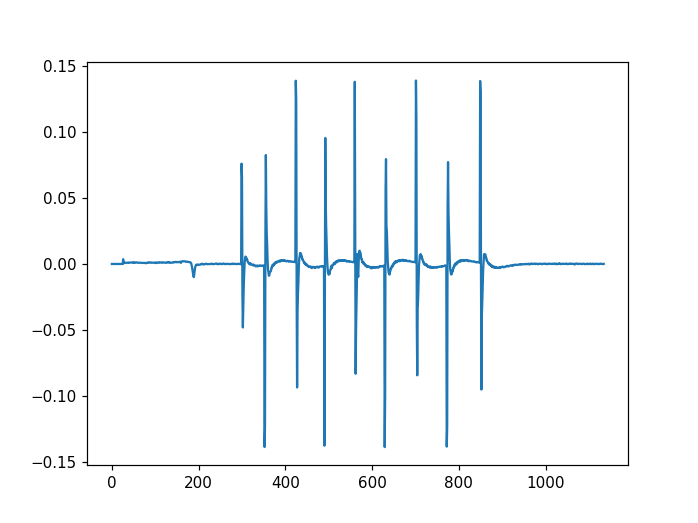

In [430]:
%matplotlib notebook
plt.plot(att[1:]-att_pred[:])
plt.show()

<IPython.core.display.Javascript object>


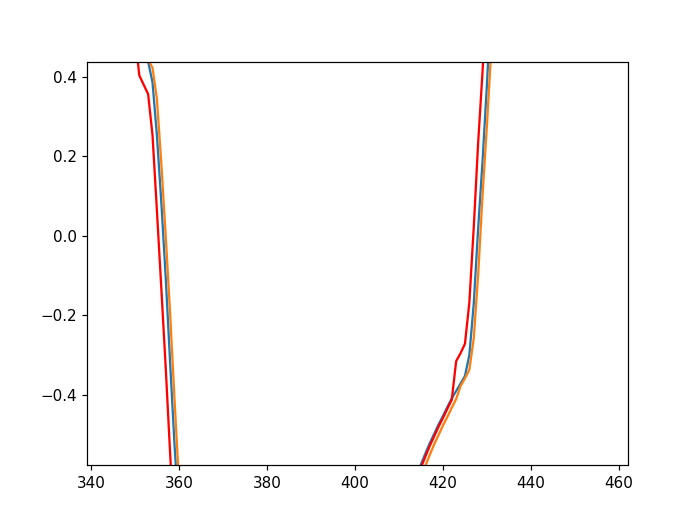

In [444]:
%matplotlib notebook
plt.plot(vel[1:])
plt.plot(vx)
plt.plot(vel_pred[1:],'r')

<IPython.core.display.Javascript object>


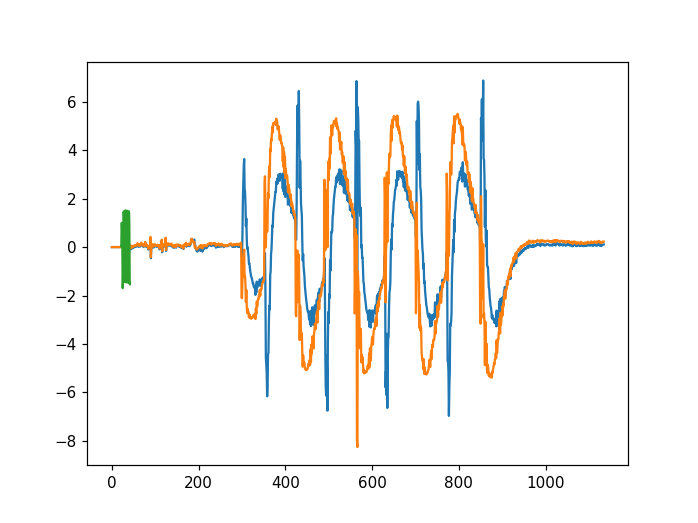

In [449]:
%matplotlib notebook 
plt.plot((vel[1:]-vx[:])/0.02)
plt.plot((vel[1:]-vel_pred[:-1])/0.02)